In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime

#### Reading historical data into one dataframe

In [2]:
directory_name = 'Case_Study_Data_For_Share/'
filepaths = [f"{directory_name}{f}" for f in os.listdir(directory_name) if f.endswith('.csv')]

In [3]:
master_df = pd.DataFrame()
for fp in filepaths:
    file_df = pd.read_csv(fp, sep='|',encoding= 'ANSI', parse_dates= ['Order Date', 'Ship Date'])
    file_df['filename'] = fp.split('/')[-1]
    master_df = master_df.append(file_df)

#### Columns cleaning and data types checking

In [4]:
## rename column names to lower case and spaces separated by _ (snake syntax)
master_df.columns = [c.lower().replace(' ','_') for c in master_df.columns]

In [5]:
master_df.dtypes

row_id                    int64
order_id                 object
order_date       datetime64[ns]
ship_date        datetime64[ns]
ship_mode                object
customer_id              object
customer_name            object
segment                  object
country                  object
city                     object
state                    object
postal_code               int64
region                   object
product_id               object
category                 object
sub-category             object
product_name             object
sales                   float64
quantity                  int64
discount                float64
profit                  float64
filename                 object
dtype: object

In [6]:
master_df.shape[0] - master_df['row_id'].max()

12163

##### File metadata

In [7]:
date_format = '%Y_%m_%d_%H_%M_%S'
master_df['reportid'] = master_df['filename'].apply(lambda x:x.split('_')[0])
master_df['create_timestamp'] = master_df['filename'].apply(lambda x:x.split('Orders_')[1].replace('.csv','').strip())
master_df['create_timestamp'] = master_df['create_timestamp'].apply(lambda x: datetime.strptime(x, date_format))
master_df['file_year'] =  master_df['reportid'].apply(lambda x:x[:4])
master_df['file_month'] = master_df['reportid'].apply(lambda x: x[-2:])

In [8]:
master_df.groupby(['reportid'], as_index=False)['filename'].nunique().head(2)

,reportid,filename
0,201901,2
1,201902,1


##### Get the latest order data from each file 

In [9]:
print(f"number of rows in master dataframe {master_df.shape[0]}")
print(f"number of orders in master dataframe {master_df['order_id'].nunique()}")
print(f"number of customers in master dataframe {master_df['customer_id'].nunique()}")
print(f"number of dates in master dataframe {master_df['order_date'].nunique()}")
print(f"total sales in master dataframe {master_df['sales'].sum()}")

number of rows in master dataframe 22157
number of orders in master dataframe 5009
number of customers in master dataframe 793
number of dates in master dataframe 1238
total sales in master dataframe 2658880.7933


In [10]:
### get only the latest updated order data.
latest_master_data = master_df.groupby(['order_id'], as_index=False)['create_timestamp'].max()
mdf = master_df.merge(latest_master_data, on =['order_id', 'create_timestamp'], how='inner')

In [11]:
print(f"number of rows in mdf dataframe {mdf.shape[0]}")
print(f"number of orders in mdf dataframe {mdf['order_id'].nunique()}")
print(f"number of customers in mdf dataframe {mdf['customer_id'].nunique()}")
print(f"number of dates in mdf dataframe {mdf['order_date'].nunique()}")
print(f"total sales in mdf dataframe {mdf['sales'].sum()}")

number of rows in mdf dataframe 9994
number of orders in mdf dataframe 5009
number of customers in mdf dataframe 793
number of dates in mdf dataframe 1238
total sales in mdf dataframe 2297200.8603000003


In [12]:
mdf.shape

(9994, 26)

Duplicated order_id and product_id

In [13]:
mdf[mdf.duplicated(subset= ['order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub-category',
       'product_name', 'filename',
       'reportid', 'create_timestamp', 'file_year', 'file_month'])]['row_id'].nunique()

8

##### Checking columns

Row ID

In [14]:
print(mdf['row_id'].nunique())

9994


Order ID

In [15]:
## all order_id has length of 14
mdf['order_id'].apply(lambda x:len(x)).unique()
mdf['order_id_prefix'] = mdf['order_id'].apply(lambda x: x.split('-')[0])
mdf['order_id_year'] = mdf['order_id'].apply(lambda x: x.split('-')[1])

In [16]:
mdf[mdf['file_year'] != mdf['order_id_year']]

,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,...,quantity,discount,profit,filename,reportid,create_timestamp,file_year,file_month,order_id_prefix,order_id_year


In [17]:
mdf.groupby(['order_id_prefix']).agg({
    'order_id' :'nunique',
    'order_date' : 'min',
    'customer_id' :'nunique',
    'product_id' :'nunique'})

,order_id,order_date,customer_id,product_id
order_id_prefix,,,,
CA,4195,2019-01-02,791,1867
US,814,2019-01-03,507,1110


Dates (order_date, ship_date) and ship_mode

In [18]:
mdf['delivery_days_diff'] = (mdf['ship_date'] - mdf['order_date']).dt.days

In [19]:
print(f"min order_date {mdf['order_date'].min()}")
print(f"max order_date {mdf['order_date'].max()}")
print("===========================================")
print(f"min ship_date {mdf['ship_date'].min()}")
print(f"max ship_date {mdf['ship_date'].max()}")
print("===========================================")
## checked that every order has only one order_date and one ship date
print(f"Case-1 : illogical  records, ship date before order creation date")
unprocessed_records_1 = mdf[mdf['order_date'] > mdf['ship_date']][['row_id', 'order_id', 'customer_id']]
unprocessed_records_1['reason'] = 'illogical  records, ship date before order creation date'
unprocessed_records_1['solution'] = 'check with business users why this happens, and apply validation criteria on source'
print(f"""{unprocessed_records_1['order_id'].nunique()} unique order from {unprocessed_records_1['customer_id'].nunique()} customer with total records of {unprocessed_records_1.shape[0]} """)

min order_date 2019-01-02 00:00:00
max order_date 2022-12-31 00:00:00
min ship_date 2019-01-02 00:00:00
max ship_date 2023-06-01 00:00:00
Case-1 : illogical  records, ship date before order creation date
909 unique order from 534 customer with total records of 1781 


ship_mode 

In [20]:
print(f"value of ship_mode for orders where order_date = ship_date : {mdf[mdf['order_date'] == mdf['ship_date']]['ship_mode'].unique()}")
print(f"put ranges for each ship_mode with business users and implement validation check that dates dont break these ranges for each ship_mode")
unprocessed_records_2 = mdf[(mdf['ship_mode'] == 'Same Day') & (mdf['delivery_days_diff'] > 0)][['row_id', 'order_id', 'customer_id']]
unprocessed_records_2['reason'] = 'ship_mode not aligned with delievery_date_diff'
unprocessed_records_2['solution'] = 'define ranges for each ship_mode with business users'

value of ship_mode for orders where order_date = ship_date : ['Same Day']
put ranges for each ship_mode with business users and implement validation check that dates dont break these ranges for each ship_mode


In [21]:
mdf[mdf['delivery_days_diff'] >= 0].groupby('ship_mode')['delivery_days_diff'].describe()

,count,mean,std,min,25%,50%,75%,max
ship_mode,,,,,,,,
First Class,1354.0,25.773264,33.017738,1.0,2.0,3.0,60.0,92.0
Same Day,535.0,0.588785,4.188788,0.0,0.0,0.0,0.0,31.0
Second Class,1671.0,35.482346,48.278925,2.0,2.0,4.0,61.0,153.0
Standard Class,4653.0,52.927144,66.039626,4.0,4.0,6.0,122.0,214.0


In [22]:
mdf[(mdf['ship_mode'] == 'Same Day') & (mdf['delivery_days_diff'] > 0)]['row_id'].nunique()

16

In [23]:
# mdf[(mdf['ship_mode'] == 'First Class') & (mdf['delivery_days_diff'] >= 0)]['delivery_days_diff'].value_counts()
### some orders might take more than 3 months to be delivered.
# mdf[mdf['delivery_days_diff'] > 90]['ship_mode'].unique()

#### Dates

In [24]:
def generate_date_series(start_date, end_date):
    dt_idx = pd.date_range(start=start_date, end=end_date)
    ts_df = pd.DataFrame(dt_idx, columns = ['date'])
    ts_df['year'] = ts_df['date'].dt.isocalendar().year
    ts_df['month'] = ts_df['date'].dt.month
    ts_df['day'] = ts_df['date'].dt.day
    ts_df['week'] = ts_df['date'].dt.isocalendar().week
    ts_df['month_name'] = ts_df['date'].dt.month_name()
    ts_df['week_day'] = ts_df['date'].dt.dayofweek
    ts_df['is_weekend'] =  ts_df.apply(lambda x : x['week_day'] > 4, axis=1)
    ts_df['weekday_name'] = ts_df['date'].dt.day_name()
    ts_df['year_day'] = ts_df['date'].dt.dayofyear
    return ts_df

In [25]:
date_df = generate_date_series(mdf['order_date'].min(),mdf['order_date'].max())

In [26]:
# date_df.to_csv('dates.csv', index=False)

pattern for missing days?

In [27]:
d1 = pd.merge(mdf, date_df, left_on='order_date',right_on ='date', how='right')
no_sales_days = d1[d1['sales'].isna()]

In [28]:
no_sales_days['weekday_name'].value_counts()

Wednesday    98
Tuesday      37
Saturday     23
Friday       18
Thursday     18
Monday       15
Sunday       13
Name: weekday_name, dtype: int64

- Product_ID has multiple names
- Product name has multiple IDs

In [29]:
t2 = mdf.groupby(['product_id'], as_index=False)['product_name'].nunique()
diff_name_product_id = t2[t2['product_name'] > 1]['product_id'].unique()
t3 = mdf.groupby(['product_name'], as_index=False)['product_id'].nunique()
diff_id_product_name = t3[t3['product_id'] > 1]['product_name'].unique()

In [30]:
mdf[(mdf['product_id'].isin(diff_name_product_id)) | (mdf['product_name'].isin(diff_id_product_name))]['row_id'].nunique()

379

##### Customers 
- Customers have multiple delivery addresses, two tables one for customer information and the other for the addresses at specific point of time

In [31]:
cust_address_df = mdf.groupby(['customer_id', 'country', 'city', 'state', 'postal_code', 'region'], as_index=False).agg(
    start_dt = pd.NamedAgg('order_date','min'))

In [32]:
cust_address_df['start_dt'] = pd.to_datetime(cust_address_df['start_dt']).dt.date
cust_address_df = cust_address_df.sort_values(['customer_id','start_dt'], ascending=[True,True])
cust_address_df['end_dt'] = cust_address_df.groupby(['customer_id'])['start_dt'].shift(-1)
cust_address_df['is_active'] = False
cust_address_df.loc[cust_address_df['end_dt'].isnull(), 'is_active'] = True

In [33]:
cust_address_df.columns

Index(['customer_id', 'country', 'city', 'state', 'postal_code', 'region',
       'start_dt', 'end_dt', 'is_active'],
      dtype='object')

In [34]:
cust_df = mdf.groupby(['customer_id'], as_index=False).agg({'customer_name':'first', 'segment':'first'})

In [35]:
# cust_address_df.to_csv('customer_addresses.csv', index=False)
# cust_df.to_csv('customers.csv', index=False)

In [36]:
df1 = mdf[['order_id', 'order_date', 'ship_date', 'customer_id']]

In [37]:
df2 = df1.merge(cust_address_df, on =['customer_id'])
df2 = df2[((df2['order_date'] >= df2['start_dt']) & (df2['order_date'] < df2['end_dt'])) | ((df2['order_date'] >= df2['start_dt']) & (df2['is_active']))]
df2.drop(columns = ['start_dt', 'end_dt'], inplace = True)

In [38]:
df2.merge(cust_df, on='customer_id', how='left')

,order_id,order_date,ship_date,customer_id,country,city,state,postal_code,region,is_active,customer_name,segment
0,CA-2019-103800,2019-04-01,2019-08-01,DP-13000,United States,Houston,Texas,77095,Central,False,Darren Powers,Consumer
1,CA-2019-122609,2019-12-11,2019-11-18,DP-13000,United States,Carrollton,Texas,75007,Central,False,Darren Powers,Consumer
2,CA-2019-122609,2019-12-11,2019-11-18,DP-13000,United States,Carrollton,Texas,75007,Central,False,Darren Powers,Consumer
3,CA-2020-115742,2020-04-18,2020-04-22,DP-13000,United States,New Albany,Indiana,47150,Central,False,Darren Powers,Consumer
4,CA-2020-115742,2020-04-18,2020-04-22,DP-13000,United States,New Albany,Indiana,47150,Central,False,Darren Powers,Consumer
...,...,...,...,...,...,...,...,...,...,...,...,...
9989,US-2022-132444,2022-11-19,2022-11-22,CD-12280,United States,Seattle,Washington,98105,West,True,Christina DeMoss,Consumer
9990,US-2022-132444,2022-11-19,2022-11-22,CD-12280,United States,Seattle,Washington,98105,West,True,Christina DeMoss,Consumer
9991,US-2022-132444,2022-11-19,2022-11-22,CD-12280,United States,Seattle,Washington,98105,West,True,Christina DeMoss,Consumer
9992,US-2022-132444,2022-11-19,2022-11-22,CD-12280,United States,Seattle,Washington,98105,West,True,Christina DeMoss,Consumer


##### products

In [39]:
t1 = mdf.groupby(['product_id'], as_index=False).agg({'product_name':'nunique'})
t2 = mdf.groupby(['product_name'], as_index=False).agg({'product_id':'nunique'})

In [40]:
t1[(t1['product_name'] > 1)]

,product_id,product_name
18,FUR-BO-10002213,2
65,FUR-CH-10001146,2
183,FUR-FU-10001473,2
284,FUR-FU-10004017,2
290,FUR-FU-10004091,2


In [41]:
## could need different category creation
product_df = mdf.groupby('product_id', as_index=False).agg(
    category = pd.NamedAgg('category','first'),
    subcategory = pd.NamedAgg('sub-category','first'),
    product_name = pd.NamedAgg('product_name','first'),
    product_name_ct = pd.NamedAgg('product_name','nunique'),
    product_name_list = pd.NamedAgg('product_name','unique'))

In [42]:
unprocessed_product_ids = product_df[product_df['product_name_ct'] > 1]['product_id'].unique()
### removed from product_df but remove orders from master also
product_df = product_df[~product_df['product_id'].isin(unprocessed_product_ids)]

In [43]:
product_df.columns

Index(['product_id', 'category', 'subcategory', 'product_name',
       'product_name_ct', 'product_name_list'],
      dtype='object')

In [44]:
# product_df[['product_id', 'category', 'subcategory', 'product_name']].to_csv('products.csv', index=False)

Quantity column

In [45]:
### how the quantity is negative?
mdf[mdf['quantity'] < 0]

,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,...,discount,profit,filename,reportid,create_timestamp,file_year,file_month,order_id_prefix,order_id_year,delivery_days_diff
819,1838,CA-2019-117345,2019-01-08,2019-05-08,Standard Class,BF-10975,Barbara Fisher,Corporate,United States,Charlotte,...,0.2,5.9211,201908_Orders_2019_09_01_04_02_26.csv,201908,2019-09-01 04:02:26,2019,08,CA,2019,120
2837,1505,CA-2020-153388,2020-01-08,2020-07-08,Standard Class,PC-19000,Pauline Chand,Home Office,United States,Los Angeles,...,0.0,3.3600,202008_Orders_2020_09_10_15_48_10.csv,202008,2020-09-10 15:48:10,2020,08,CA,2020,182
5224,8168,CA-2021-144148,2021-01-08,2021-06-08,Standard Class,AH-10690,Anna Häberlin,Corporate,United States,San Francisco,...,0.2,-32.3673,202108_Orders_2021_09_10_15_19_50.csv,202108,2021-09-10 15:19:50,2021,08,CA,2021,151
8097,9439,CA-2022-126144,2022-01-08,2022-06-08,Standard Class,GM-14680,Greg Matthias,Consumer,United States,Philadelphia,...,0.4,-57.1152,202208_Orders_2022_09_10_12_41_11.csv,202208,2022-09-10 12:41:11,2022,08,CA,2022,151


<AxesSubplot:>

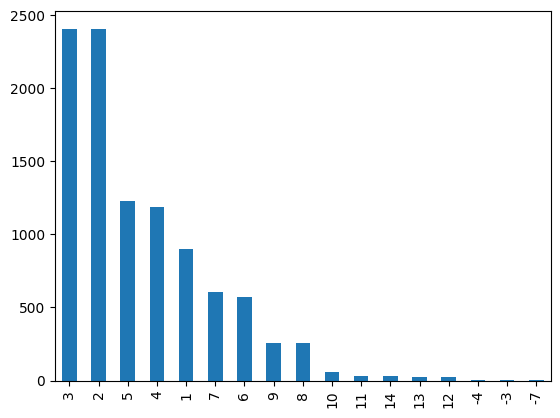

In [46]:
mdf['quantity'].value_counts().sort_values(ascending=False).plot(kind='bar')

Sales

In [47]:
## impute the profit by having the cost/price for a specific date
mdf['unit_price_after_discount'] = mdf['sales'] / mdf['quantity']
mdf['unit_price'] = mdf['unit_price_after_discount'] / (1- mdf['discount']).round(2)
mdf['unit_price'] = mdf['unit_price'].apply(lambda x: '{:.2f}'.format(x))

In [48]:
t1 = mdf.groupby(['order_date', 'product_id'], as_index=False)['unit_price'].nunique()
t1[t1['unit_price'] >1]

,order_date,product_id,unit_price


discount

In [49]:
### is discount rate unique per date,product?
## segment, customer?
t2 = mdf.groupby(['order_date', 'product_id'], as_index=False)['discount'].nunique()
t2[t2['discount'] > 1]

,order_date,product_id,discount
1019,2019-08-15,OFF-BI-10003638,2
2111,2020-02-10,OFF-BI-10001757,2
2128,2020-02-11,OFF-BI-10001524,2
2214,2020-03-10,FUR-BO-10004409,2
2379,2020-04-13,FUR-TA-10002530,2
2851,2020-07-11,FUR-CH-10000595,2
3236,2020-09-17,FUR-BO-10004834,2
3633,2020-11-13,OFF-PA-10001790,2
3989,2020-12-21,TEC-AC-10003198,2
4565,2021-04-11,OFF-BI-10003981,2


profit

In [50]:
### profit data disconnection for following days
mdf[mdf['profit'].isnull()]['row_id'].nunique()

234

In [51]:
mdf[mdf['delivery_days_diff'] >= 90]['row_id'].nunique()

2021

In [52]:
cols_ = ['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'product_id', 'sales', 'quantity', 'discount', 'profit','delivery_days_diff',
       'unit_price_after_discount', 'unit_price']

In [53]:
# mdf[cols_].to_csv('sales.csv', index=False)

Task_6_2_Data_Marts_Rows.csv

In [55]:
rows_detail_list = [{'Data Mart System Name' : 'customers', 'Count Rows': cust_df.shape[0], 'Count Distinct PK' :cust_df['customer_id'].nunique()},
{'Data Mart System Name' : 'customer_addresses', 'Count Rows': cust_address_df.shape[0], 'Count Distinct PK' :cust_address_df[['customer_id', 'start_dt']].nunique().values},
{'Data Mart System Name' : 'products', 'Count Rows': product_df.shape[0], 'Count Distinct PK' :product_df['product_id'].nunique()},
{'Data Mart System Name' : 'dates', 'Count Rows': date_df.shape[0], 'Count Distinct PK' :date_df['date'].nunique()},
{'Data Mart System Name' : 'sales', 'Count Rows': mdf.shape[0], 'Count Distinct PK' :mdf['row_id'].nunique()}]


In [56]:
# pd.DataFrame(rows_detail_list).sort_values("Count Rows", ascending = False).to_csv('Task_6_2_Data_Marts_Rows.csv', index=False)